In [1]:
%%capture
!wget https://github.com/DataTalksClub/nyc-tlc-data/releases/download/fhv/fhv_tripdata_2019-10.csv.gz
!wget https://github.com/DataTalksClub/nyc-tlc-data/releases/download/misc/taxi_zone_lookup.csv
!gunzip fhv_tripdata_2019-10.csv.gz

In [2]:
import pyspark
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as f

# Create a Spark session
spark = SparkSession.builder.appName("Week5Pyspark").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/03/04 02:56:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Question 1

In [3]:
spark.version

'3.3.2'

In [4]:
# Set up
def get_csv():
    # Define the schema
    schema = types.StructType([
        types.StructField('dispatching_base_num', types.StringType(), True),
        types.StructField('pickup_datetime', types.TimestampType(), True),
        types.StructField('dropoff_datetime', types.TimestampType(), True),
        types.StructField('PULocationID', types.IntegerType(), True),
        types.StructField('DOLocationID', types.IntegerType(), True),
        types.StructField('SR_Flag', types.StringType(), True),
        types.StructField('Affiliated_base_number', types.StringType(), True),
    ])

    # Read the CSV
    df = (
        spark.read
        .option('header', 'true')
        .schema(schema)
        .csv('fhv_tripdata_2019-10.csv')
    )

    return df

# Get spark dataframe from the CSV file
df = get_csv()

#### Quetion 2

In [5]:
def question_2():
    import os

    # Partition
    folder_path = 'fhvhv/2019/10/'
    df.repartition(6).write.parquet(folder_path)

    # Empty list for each parquet size
    parquet_sizes = []

    # Iterate through files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.parquet'):
            file_path = os.path.join(folder_path, file_name)
            file_size = os.path.getsize(file_path)
            file_size_mb = file_size / (1024 * 1024)  # Convert bytes to MB
            parquet_sizes.append( file_size_mb)

    # Calculate the average
    parquet_sizes_avg = sum(parquet_sizes) / len(parquet_sizes)
    print(f'Average size of the parquet: {parquet_sizes_avg:.2f}')

# Call the function
question_2()  # >> Average size of the parquet: 6.24

Average size of the parquet: 6.13


#### Question 3

In [6]:
'''How many taxi trips were there on the 15th of October?
Consider only trips that started on the 15th of October.
>> 62,610
'''
df.filter(f.dayofmonth('pickup_datetime') == 15).count()

62610

#### Question 4

In [7]:
'''Longest trip for each day.
What is the length of the longest trip in the dataset in hours?
>> 631,152.50 Hours
'''
res = (df
    .withColumn('trip_duration_hours', (f.col('dropoff_datetime').cast('long') - f.col('pickup_datetime').cast('long')) / 3600)
    .select(f.max('trip_duration_hours'))
)

res.show()

+------------------------+
|max(trip_duration_hours)|
+------------------------+
|                631152.5|
+------------------------+



#### Question 5

In [8]:
'''User Interface
Spark’s User Interface which shows the application's dashboard runs on which local port?
>> 4040
'''
4040

4040

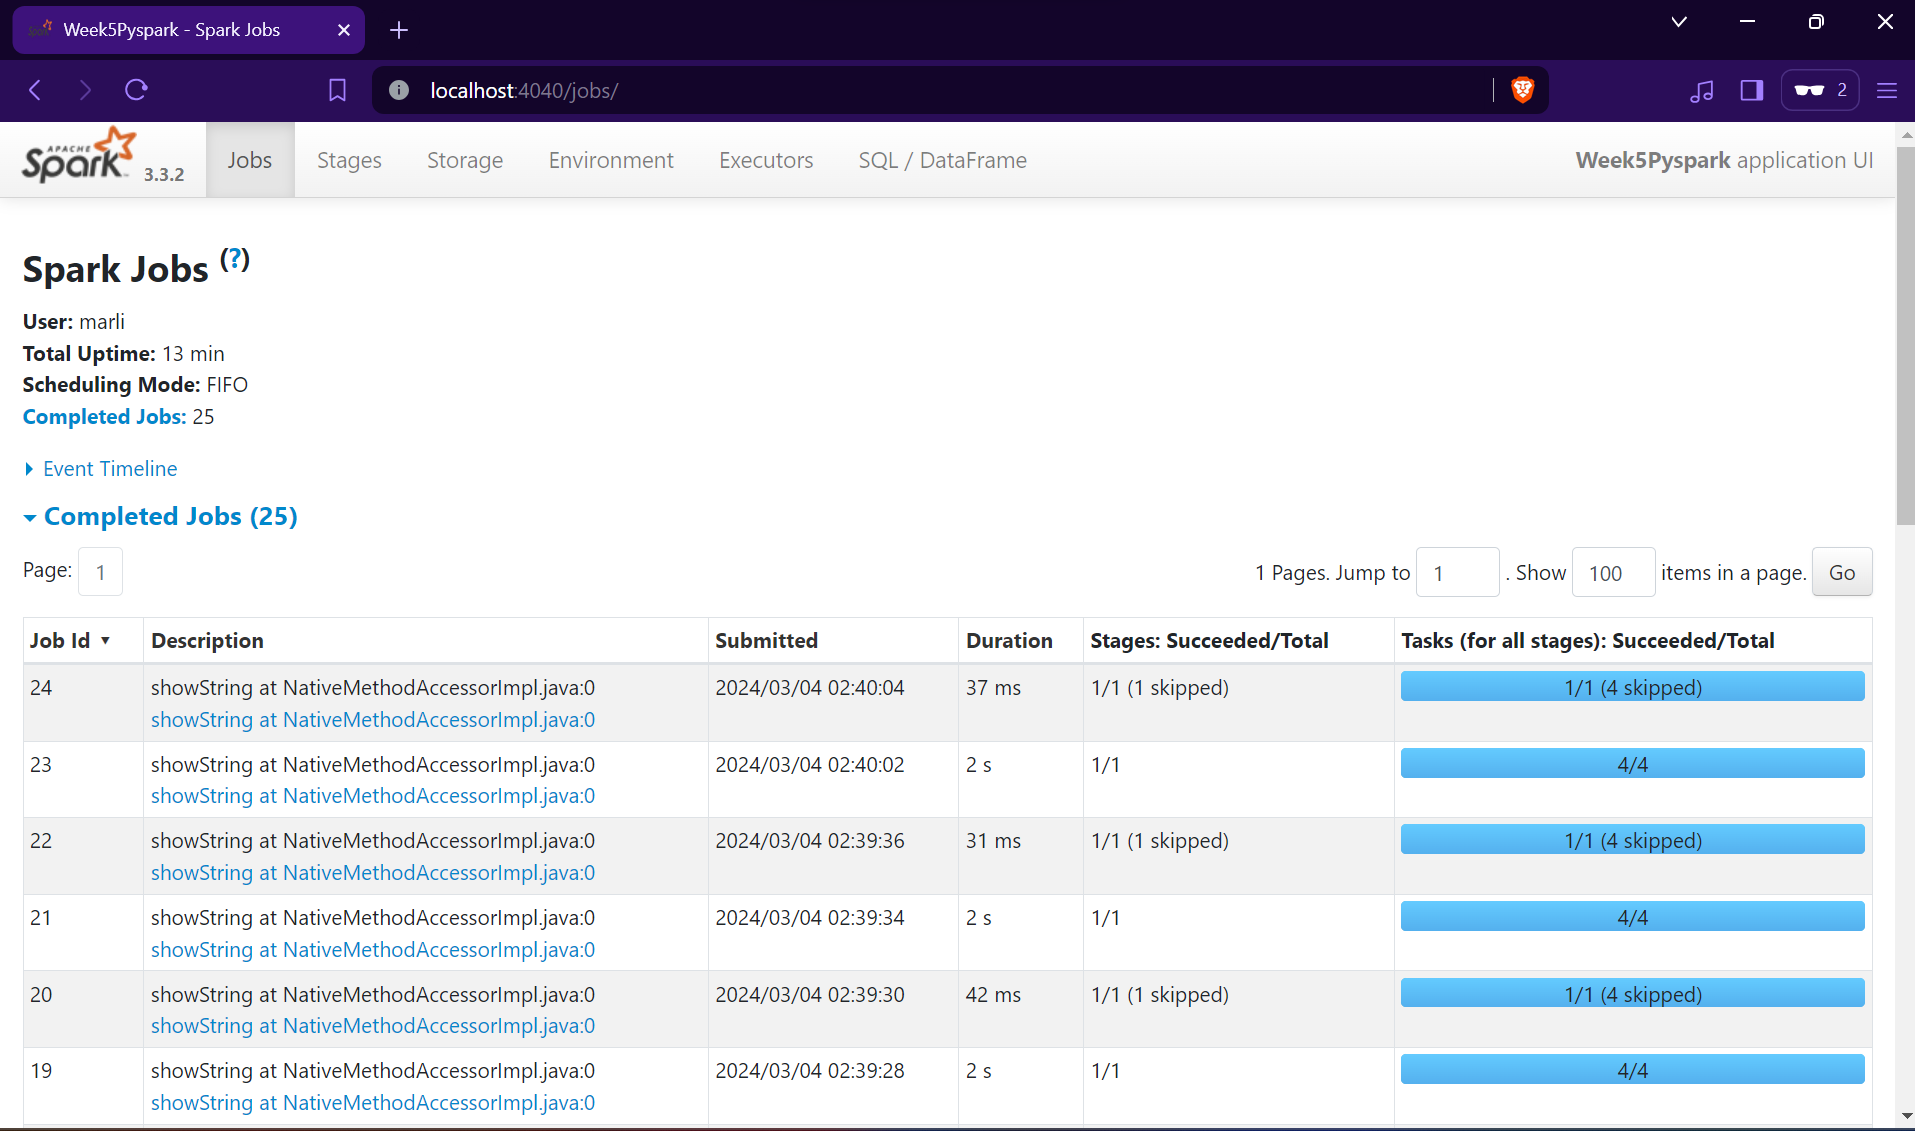

#### Question 6

In [9]:
'''Least frequent pickup location zone
Using the zone lookup data and the FHV October 2019 data, what is the name of the LEAST frequent pickup location Zone?

>> Jamaica Bay
'''
# LEAST frequent pickup location Zone
least_freq_PU = (
  df.select('PULocationID')
  .groupBy('PULocationID')
  .agg(f.count('PULocationID').alias('count'))
  .dropna(how='any', subset=['PULocationID'])
  .orderBy('count')
  .limit(1)
)

# Print the least frequent pickup location Zone in ID
least_freq_PU.show()


# Read the lookup CSV
lookup_df = (
    spark.read
    .option('header', 'true')
    .option("inferSchema", "true")
    .csv('taxi_zone_lookup.csv')
)

# Query the result
res = (
    lookup_df
    .filter( f.col('LocationID') == least_freq_PU.collect()[0][0] )
)

# Print the result
res.show()

+------------+-----+
|PULocationID|count|
+------------+-----+
|           2|    1|
+------------+-----+



+----------+-------+-----------+------------+
|LocationID|Borough|       Zone|service_zone|
+----------+-------+-----------+------------+
|         2| Queens|Jamaica Bay|   Boro Zone|
+----------+-------+-----------+------------+



In [10]:
# delete all resources
!sudo rm -r fhvhv
!sudo rm fhv_tripdata_2019-10.csv
!sudo rm taxi_zone_lookup.csv
